In [39]:
import h5py
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

## Input

In [40]:
sad_h5_file = 'ponies_sad/sad.h5'
targets_file = '/home/drk/farm/data/basenji/data/v4/targets_h.txt'

In [81]:
# open scores h5
sad_h5 = h5py.File(sad_h5_file, 'r')

# read targets
targets_df = pd.read_table(targets_file, index_col=0, usecols=['index', 'identifier', 'description', 'file'])
num_targets = targets_df.shape[0]

## Helpers

In [43]:
def write_bedgraph(bedg_file, chrm, start, values, step=128):
    bedg_open = open(bedg_file, 'w')
    
    vstart = start
    for v in values:
        print('%s\t%d\t%d\t%f' % (chrm, vstart, vstart+step, v), file=bedg_open)
        vstart += step
        
    bedg_open.close()

## Choose sequence/target

In [44]:
variant = 'chr16_57025062_C_T_b38'
for li, label in enumerate(sad_h5['snp']):
    label = label.decode('UTF-8')
    if label.startswith(variant):
        print(li)

4


In [45]:
vi = 4

In [46]:
cage_mask = np.array([desc.startswith('CAGE') for desc in targets_df.description])
artery_mask = np.array([desc.find('artery') != -1 for desc in targets_df.description])
targets_df.loc[cage_mask & artery_mask]

,identifier,description
index,,
4748,CNhs10839,"CAGE:Smooth Muscle Cells - Umbilical artery,"
5164,CNhs12843,"CAGE:artery, adult"


In [83]:
ti = 4765

'/home/drk/tillage/datasets/human/cage/fantom/CNhs10860/summary/coverage.w5'

## Single target

In [68]:
# read predictions

preds_ref = sad_h5['REF'][vi,:,ti].astype('float32')
preds_alt = sad_h5['ALT'][vi,:,ti].astype('float32')
preds_ref.shape

(896,)

In [69]:
# determine region

chrm = sad_h5['chr'][vi].decode('UTF-8')
pos = sad_h5['pos'][vi]
start = pos - 128*preds_ref.shape[0]//2
end = start + 128*preds_ref.shape[0]
'%s:%d-%d' % (chrm,start,end)

'chr16:56967718-57082406'

In [ ]:
# read targets

with h5py.File(targets_df.iloc[ti].file,'r') as target_w5:
    region_targets = target_w5[chrm][start:end]
    
# sum in bins
region_targets = np.reshape(region_targets, (-1,128)).sum(axis=-1)

# clip
region_targets = np.clip(region_targets, 0, 384)
region_targets.shape

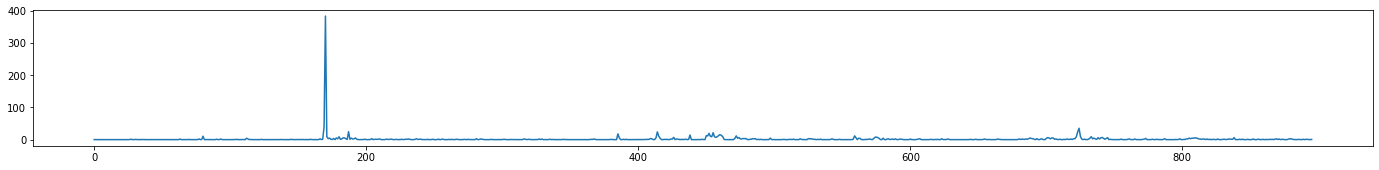

In [86]:
plt.figure(figsize=(24,2.5))
plt.plot(region_targets)

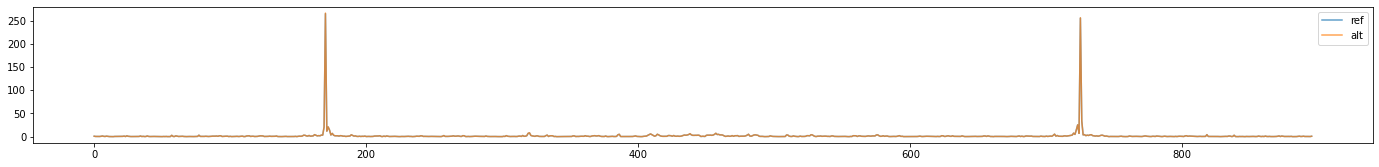

In [87]:
plt.figure(figsize=(24,2.5))
plt.plot(preds_ref, alpha=0.7, label='ref')
plt.plot(preds_alt, alpha=0.7, label='alt')
plt.legend()

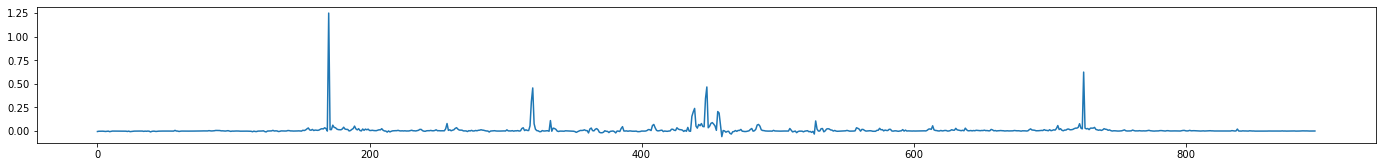

In [88]:
plt.figure(figsize=(24,2.5))
plt.plot(preds_alt-preds_ref)

In [89]:
# bedgraph_prefix = 'nlrc5_t%d' % ti
# write_bedgraph('%s_data.bedgraph' % bedgraph_prefix, chrm, start, region_targets)
# write_bedgraph('%s_pred.bedgraph' % bedgraph_prefix, chrm, start, preds_alt)
# write_bedgraph('%s_diff.bedgraph' % bedgraph_prefix, chrm, start, preds_alt-preds_ref)

## Meta targets

In [13]:
preds_ref = sad_h5['REF'][vi].astype('float32')
preds_alt = sad_h5['ALT'][vi].astype('float32')
preds_ref.shape

(896, 5313)

In [14]:
target_mask = np.array([desc.startswith('CAGE') for desc in targets_df.description])
# target_mask = np.array([desc.startswith('DNASE') for desc in targets_df.description])
preds_ref = preds_ref[:,target_mask]
preds_alt = preds_alt[:,target_mask]

/home/drk/anaconda3/envs/py38/lib/python3.8/site-packages/seaborn/matrix.py:649: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


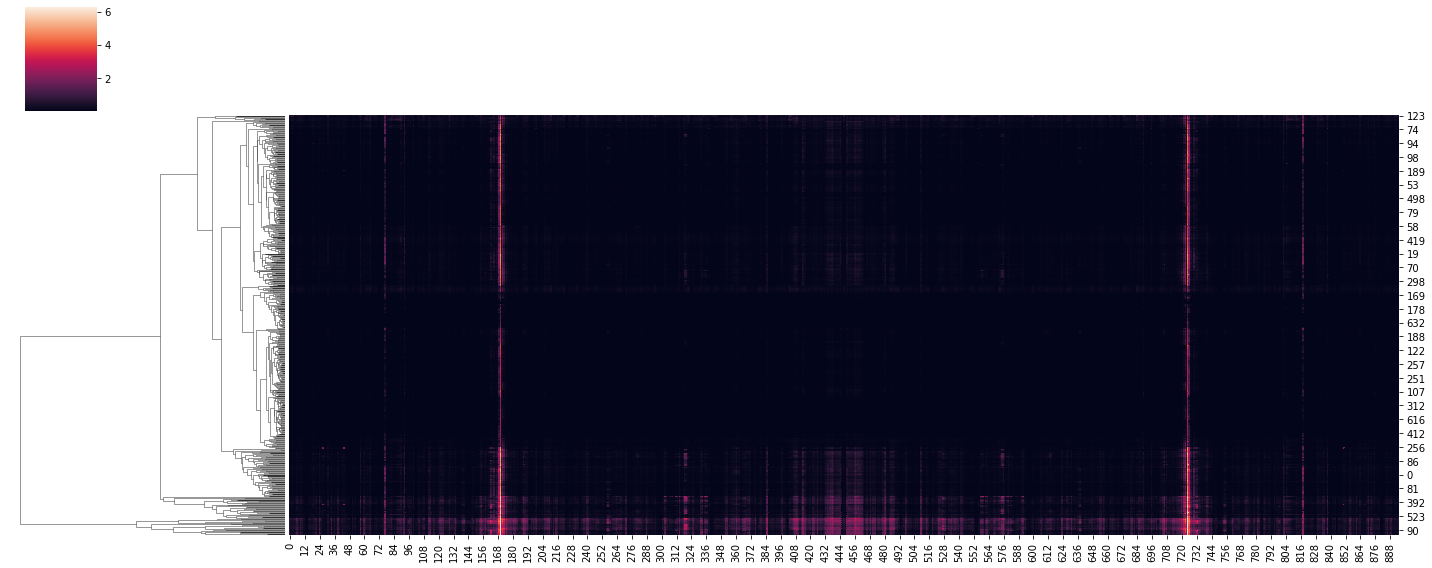

In [15]:
# reference prediction
sns.clustermap(np.arcsinh(preds_ref).T, col_cluster=False, figsize=(20,8))

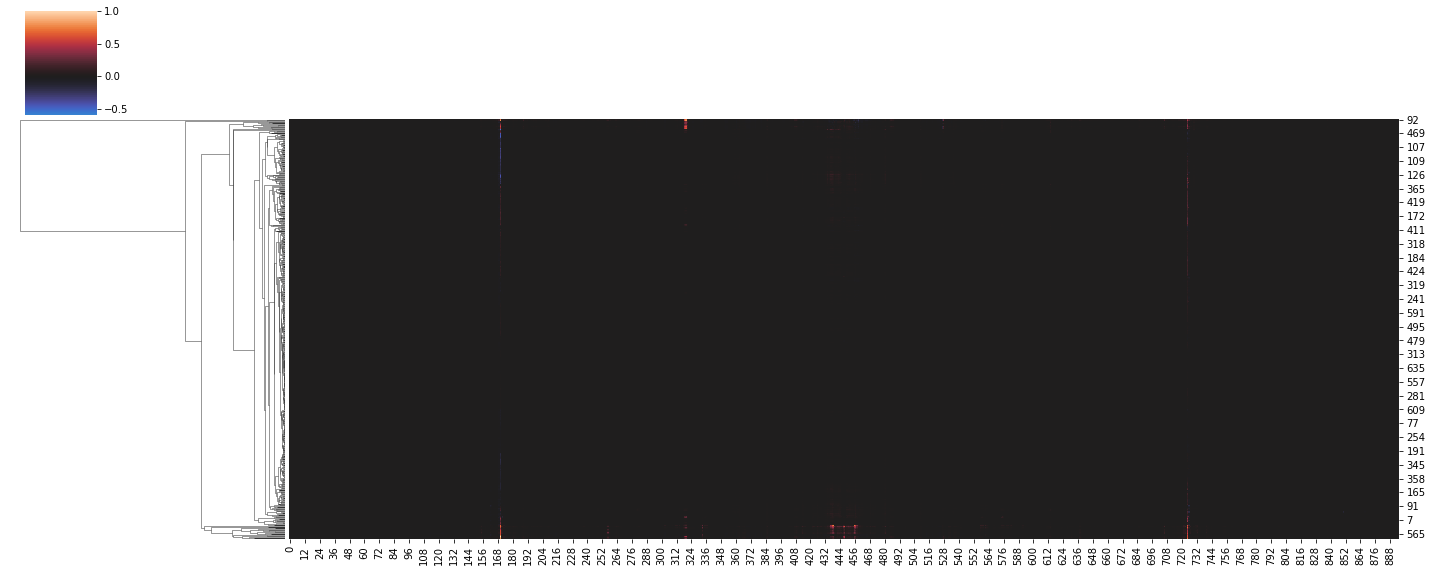

In [16]:
# diff

sns.clustermap(np.arcsinh(preds_alt-preds_ref).T, center=0, vmax=1, col_cluster=False, figsize=(20,8))

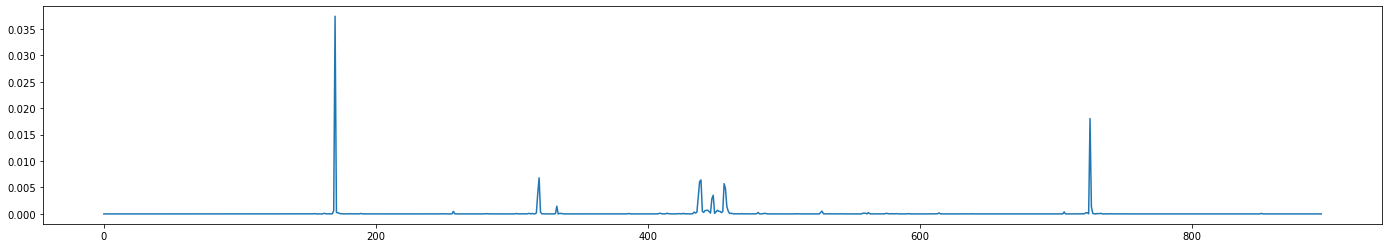

In [17]:
# variance across targets by position

plt.figure(figsize=(24,4))
plt.plot(np.arcsinh(preds_alt-preds_ref).var(axis=1))

## Rank interesting positions

In [1]:
xi = np.argmax(np.arcsinh(preds_alt-preds_ref).var(axis=1))
xi

NameError: name 'np' is not defined

In [19]:
sad_pos = (preds_alt-preds_ref)[xi]
df_rank = targets_df[target_mask].copy()
df_rank['SAD'] = sad_pos
df_rank.sort_values('SAD').tail(20)

,identifier,description,SAD
index,,,
5242,CNhs13487,"CAGE:CD14+ monocytes - treated with Cryptococcus,",0.62500
4806,CNhs11671,"CAGE:Whole blood (ribopure), , donation2",0.62500
4805,CNhs11675,"CAGE:Whole blood (ribopure), , donation1",0.62500
4759,CNhs11955,"CAGE:CD4+ T Cells,",0.62500
5244,CNhs13495,"CAGE:CD14+ monocytes - treated with B-glucan,",0.62500
5238,CNhs13484,"CAGE:CD14+ monocytes - mock treated,",0.62500
5239,CNhs13532,CAGE:CD14+ monocytes - treated with Group A st...,0.62500
5240,CNhs13533,CAGE:CD14+ monocytes - treated with lipopolysa...,0.62500
5214,CNhs13207,"CAGE:CD14-CD16+ Monocytes,",0.62500
